# Image Captioning (Combining CNN & RNN model)

### Author:
Student: Sang Luong <br>
Student ID: 436820 <br>
Instructor: Professor. Robert Wojciechowski

### Import packages

In [2]:
import pandas as pd
import numpy as np
import time
from numpy.random import seed
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed, Bidirectional,RepeatVector
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
import collections
import sklearn
import tensorflow
import tensorflow.keras as keras
import pprint
from skimage import io
from skimage.transform import resize
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
import cv2, json
import random
import pickle
import urllib.request
from PIL import Image
import itertools
import nltk
from IPython.display import display, Image

## I. Introduction to the analyzed problem

-Image captioning, which is one of the most fundamental task in Deep learning domain, is the process of automatically generating natural language descriptions for given images. <br>
-Image captioning combines both the process of image and natural language processing. For the Language part, we use GRU model in Recurrent Neural Networks (RNN) and for the Image part, we use Convolutional Neural Networks (CNN) to obtain the feature vectors respectively. <br>
-Application of Image captioning: An application suggesting captions for images on social media platforms, an application to help people who have low or no eyesight and so on. <br>

## II. Data set description

-For my project, I will use data set from https://cocodataset.org and the name of my data set is: 2014 Train/Val Annotations. <br>
-Data set consists of 2 parts: Image part and Caption part <br>
-For images part, the data is a list of dictionaries includes 6 keys in each dictionary: <br>
* license: license of this image
* file_name: the name of this image with format *.jpg
* coco_url: the online url link to download this pictures from COCO website
* height: specifies the height of image, in pixel
* width: specifies the width of image, in pixel
* date_captured: specifies time when this image is captured
* flickr_url: the online url link to download this pictures from Flickr website
* id: the id of this image. It's the Key to link the image with the Caption.

-For caption part, the data is a list of dictionaries includes 3 keys in each dictionary: <br>
* image_id: the ID of given image that this caption is related to. This Key is link with Key 'id' in image part. <br>
  NOTE that: each image can have more than one caption.
* id: the id of this caption
* caption: natural language describing the given image.

## III. Data Processing

In [3]:
with open('annotations/captions_train2014.json') as f:
    annotations = json.load(f)

In [4]:
image_path_to_caption = collections.defaultdict(list)

In [5]:
PATH = 'http://images.cocodataset.org/train2014/'

In [6]:
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [7]:
image_paths = list(image_path_to_caption.keys())
random.Random(123).shuffle(image_paths)
len(image_paths)

82783

In [8]:
train_image_paths = image_paths[:5000]
test_image_paths = image_paths[5000:5500]
len(train_image_paths)

5000

In [9]:
len(test_image_paths)

500

In [10]:
train_captions = []
train_img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    train_img_name_vector.extend([image_path] * len(caption_list))

In [11]:
df_train = pd.DataFrame()

In [12]:
df_train['image_id'] = train_img_name_vector
df_train['caption'] = train_captions

In [13]:
df_train

,image_id,caption
0,http://images.cocodataset.org/train2014/COCO_t...,<start> A young woman talking on a cell phone ...
1,http://images.cocodataset.org/train2014/COCO_t...,<start> A woman near bushes on a cell phone <end>
2,http://images.cocodataset.org/train2014/COCO_t...,<start> A woman stands on a street talking on ...
3,http://images.cocodataset.org/train2014/COCO_t...,<start> A young woman looks somber while using...
4,http://images.cocodataset.org/train2014/COCO_t...,<start> A woman with long hair talking on a ce...
...,...,...
25011,http://images.cocodataset.org/train2014/COCO_t...,<start> A pile of ripe dole bananas sitting on...
25012,http://images.cocodataset.org/train2014/COCO_t...,<start> This is a bundle of yellow Dole banana...
25013,http://images.cocodataset.org/train2014/COCO_t...,<start> there is a dole sticker on this bunch ...
25014,http://images.cocodataset.org/train2014/COCO_t...,<start> There is no image on this page to desc...


['<start> A young woman talking on a cell phone while standing next to a busy '
 'street. <end>',
 '<start> A woman near bushes on a cell phone <end>',
 '<start> A woman stands on a street talking on her cellphone. <end>',
 '<start> A young woman looks somber while using a cell phone. <end>',
 '<start> A woman with long hair talking on a cellphone. <end>']


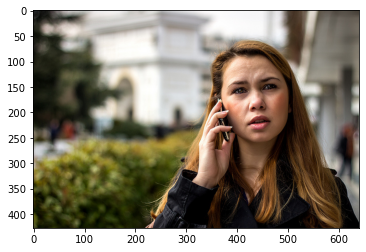

In [14]:
urllib.request.urlretrieve(train_img_name_vector[0], train_img_name_vector[0][-16:])
img = Image.open(train_img_name_vector[0][-16:])
plt.imshow(img)
pprint.pprint(image_path_to_caption[train_img_name_vector[0]])

## IV. Preprocess image using VGG16

In [15]:
model_CNN = VGG16(weights='imagenet',input_shape=(224,224,3))

In [16]:
model_CNN.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
model_CNN = Model(inputs=model_CNN.inputs, outputs= model_CNN.layers[-2].output)

In [33]:
def load_image(image_path):
    urllib.request.urlretrieve(image_path, image_path[-16:])
    image = load_img(image_path[-16:], target_size = (224,224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) #reshape image to have same dimension with input of model
    image = preprocess_input(image)   #adequate your image to the format the model requires
    image_extract_feature = model_CNN.predict(image)
    return image_extract_feature

In [32]:
train_image_paths

['http://images.cocodataset.org/train2014/COCO_train2014_000000223571.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000019131.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000102842.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000232936.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000080207.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000030195.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000027293.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000486413.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000515426.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000399512.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000551418.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000441034.jpg',
 'http://images.cocodataset.org/train2014/COCO_train2014_000000511454.jpg',
 'http://ima

In [41]:
#This syntax take a long time to operate, I run it one time and save a list image_array to local disk with the name "image_arrays.pkl"
image_extract_feature_arrays = []
for image_path in train_image_paths:
    image_extract_feature = load_image(image_path)
    image_extract_feature_arrays.extend([image_extract_feature])

In [42]:
len(image_extract_feature_arrays)

5000

In [44]:
image_extract_feature_arrays[0].shape

(1, 4096)

In [45]:
keys_list = train_image_paths
values_list = image_extract_feature_arrays
zip_iterator = zip(keys_list, values_list) 
a_dictionary = dict(zip_iterator) 

In [46]:
train_img_extract_feature = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_img_extract_feature.extend([a_dictionary[image_path].reshape(1,4096)] * len(caption_list))

In [47]:
len(train_img_extract_feature)

25016

In [48]:
X_train_image = np.concatenate( train_img_extract_feature, axis=0 )

## V. Tokenize captions and create vocabulary for training data

In [49]:
df_train['caption'] = df_train['caption'].str.lower()

In [50]:
df_train['caption_token'] = df_train['caption'].apply(lambda x: x.split())

In [51]:
df_train

,image_id,caption,caption_token
0,http://images.cocodataset.org/train2014/COCO_t...,<start> a young woman talking on a cell phone ...,"[<start>, a, young, woman, talking, on, a, cel..."
1,http://images.cocodataset.org/train2014/COCO_t...,<start> a woman near bushes on a cell phone <end>,"[<start>, a, woman, near, bushes, on, a, cell,..."
2,http://images.cocodataset.org/train2014/COCO_t...,<start> a woman stands on a street talking on ...,"[<start>, a, woman, stands, on, a, street, tal..."
3,http://images.cocodataset.org/train2014/COCO_t...,<start> a young woman looks somber while using...,"[<start>, a, young, woman, looks, somber, whil..."
4,http://images.cocodataset.org/train2014/COCO_t...,<start> a woman with long hair talking on a ce...,"[<start>, a, woman, with, long, hair, talking,..."
...,...,...,...
25011,http://images.cocodataset.org/train2014/COCO_t...,<start> a pile of ripe dole bananas sitting on...,"[<start>, a, pile, of, ripe, dole, bananas, si..."
25012,http://images.cocodataset.org/train2014/COCO_t...,<start> this is a bundle of yellow dole banana...,"[<start>, this, is, a, bundle, of, yellow, dol..."
25013,http://images.cocodataset.org/train2014/COCO_t...,<start> there is a dole sticker on this bunch ...,"[<start>, there, is, a, dole, sticker, on, thi..."
25014,http://images.cocodataset.org/train2014/COCO_t...,<start> there is no image on this page to desc...,"[<start>, there, is, no, image, on, this, page..."


In [52]:
def make_lexicon(token_seqs, min_freq=1):
    token_counts = {}
    for seq in token_seqs:
        for token in seq:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1
    return token_counts

In [53]:
vocabulary = make_lexicon(token_seqs = df_train['caption_token'] )
voca = vocabulary.keys()
count = vocabulary.values()

In [54]:
df_voca = pd.DataFrame()
df_voca['voca'] = voca
df_voca['count'] = count

In [55]:
df_voca

,voca,count
0,<start>,25016
1,a,41467
2,young,674
3,woman,1492
4,talking,109
...,...,...
10122,auditorium,1
10123,gable,1
10124,dole,3
10125,page,1


In [56]:
sum(df_voca['count'])

311842

In [57]:
df_voca_1 = df_voca[df_voca['count'] >= 2]

In [58]:
sum(df_voca_1['count'])

307231

<AxesSubplot:title={'center':'Caption length distribution'}, ylabel='Frequency'>

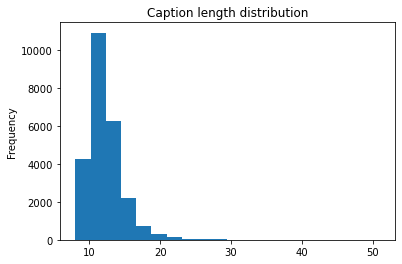

In [358]:
df_train['caption_token'].apply(lambda x: len(x)).plot(kind = 'hist',title = 'Caption length distribution', bins = 20)

**Discussion**: Captions are most distributed in interval between 10 and 15 words

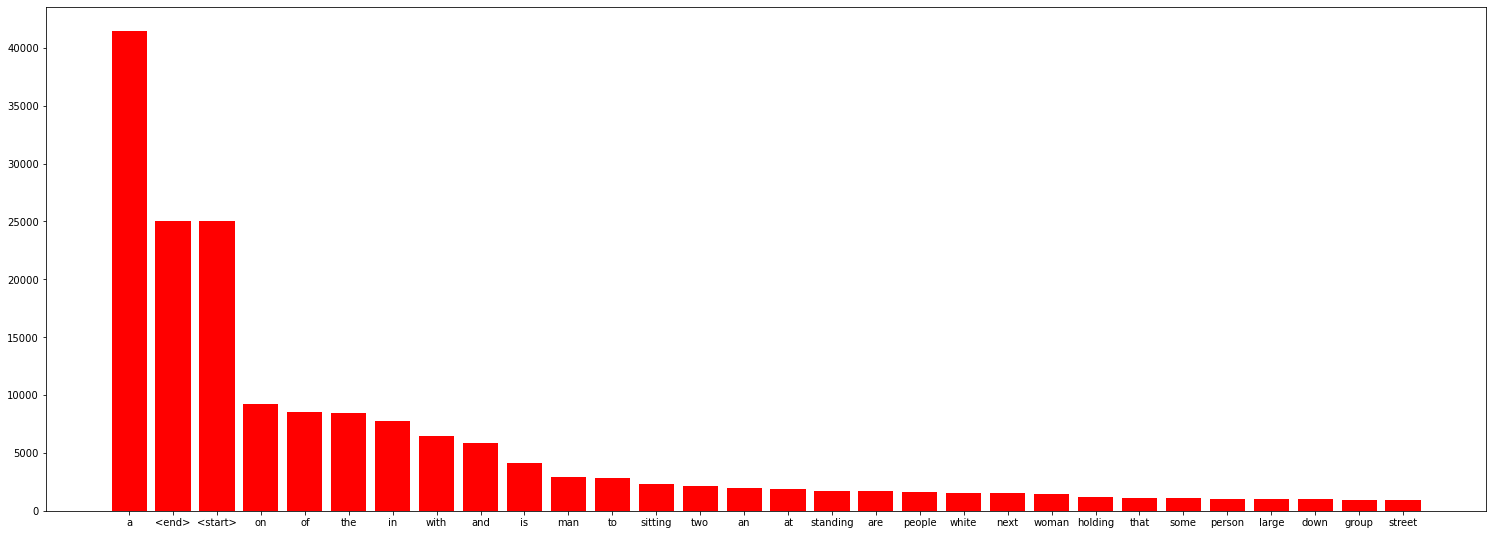

In [357]:
df_2 = df_voca_1.sort_values(by=['count'], ascending = False).head(30)
fig = plt.figure(figsize = (20,7))
ax = fig.add_axes([0,0,1,1])
ax.bar(df_2['voca'],df_2['count'], color = 'red')
plt.show()


**Discussion**: In our vocabulary, preposition words appears most frequently and following by 'man', 'siting'... words.

In [59]:
word_to_int = {}
int_to_word = {}

In [60]:
for i, c in enumerate (list(df_voca_1['voca'])) :
    word_to_int.update({c: i+2}) # preserve 0 for padding, 1 for <unk< token
    int_to_word.update({i+2: c})

In [61]:
int_to_word[0]=""
int_to_word[1]= "<unk>"
word_to_int[""] = 0
word_to_int["<unk>"] = 1

In [62]:
len(word_to_int)

5518

In [63]:
def words_idx(captions, word_to_int):
    word_idx = [[word_to_int[word] if word in word_to_int.keys() else 1 for word in caption] for caption in captions ]
    return word_idx

In [64]:
df_train['caption_token_idx'] = words_idx(captions = df_train['caption_token'], word_to_int = word_to_int)

In [65]:
df_train

,image_id,caption,caption_token,caption_token_idx
0,http://images.cocodataset.org/train2014/COCO_t...,<start> a young woman talking on a cell phone ...,"[<start>, a, young, woman, talking, on, a, cel...","[2, 3, 4, 5, 6, 7, 3, 8, 9, 10, 11, 12, 13, 3,..."
1,http://images.cocodataset.org/train2014/COCO_t...,<start> a woman near bushes on a cell phone <end>,"[<start>, a, woman, near, bushes, on, a, cell,...","[2, 3, 5, 17, 18, 7, 3, 8, 9, 16]"
2,http://images.cocodataset.org/train2014/COCO_t...,<start> a woman stands on a street talking on ...,"[<start>, a, woman, stands, on, a, street, tal...","[2, 3, 5, 19, 7, 3, 20, 6, 7, 21, 22, 16]"
3,http://images.cocodataset.org/train2014/COCO_t...,<start> a young woman looks somber while using...,"[<start>, a, young, woman, looks, somber, whil...","[2, 3, 4, 5, 23, 1, 10, 24, 3, 8, 25, 16]"
4,http://images.cocodataset.org/train2014/COCO_t...,<start> a woman with long hair talking on a ce...,"[<start>, a, woman, with, long, hair, talking,...","[2, 3, 5, 26, 27, 28, 6, 7, 3, 22, 16]"
...,...,...,...,...
25011,http://images.cocodataset.org/train2014/COCO_t...,<start> a pile of ripe dole bananas sitting on...,"[<start>, a, pile, of, ripe, dole, bananas, si...","[2, 3, 1606, 45, 738, 5517, 1170, 32, 7, 3, 31..."
25012,http://images.cocodataset.org/train2014/COCO_t...,<start> this is a bundle of yellow dole banana...,"[<start>, this, is, a, bundle, of, yellow, dol...","[2, 154, 43, 3, 2988, 45, 697, 5517, 1167, 16]"
25013,http://images.cocodataset.org/train2014/COCO_t...,<start> there is a dole sticker on this bunch ...,"[<start>, there, is, a, dole, sticker, on, thi...","[2, 128, 43, 3, 5517, 2904, 7, 154, 562, 45, 1..."
25014,http://images.cocodataset.org/train2014/COCO_t...,<start> there is no image on this page to desc...,"[<start>, there, is, no, image, on, this, page...","[2, 128, 43, 664, 494, 7, 154, 1, 13, 1, 16]"


In [66]:
max_caption_len = max([len(idx_word) for idx_word in df_train['caption_token_idx']]) # Get length of longest caption
max_caption_len 

51

In [67]:
caption_padded_idxs = pad_sequences(df_train['caption_token_idx'], maxlen=max_caption_len)

In [68]:
X_train_language = caption_padded_idxs[:,:-1]
Y_train = caption_padded_idxs[:, 1:, None] #(y) has extra 3rd dimension added because sparse cross-entropy function requires one label per row

In [337]:
image_feature = ['image feature', 'image feature', 'image feature', '...', 'image feature']
inputs = ['<start>', '<start> a' , '<start> a young','...','<start> a young...street.']
outputs = ['a', 'young','women','...','<end>' ]
Model_illustration = pd.DataFrame()
Model_illustration ['image_feature'] = image_feature
Model_illustration ['inputs'] = inputs
Model_illustration ['outputs'] = outputs
Model_illustration

,image_feature,inputs,outputs
0,image feature,<start>,a
1,image feature,<start> a,young
2,image feature,<start> a young,women
3,...,...,...
4,image feature,<start> a young...street.,<end>


In [69]:
X_train_language.shape

(25016, 50)

In [70]:
Y_train.shape

(25016, 50, 1)

In [72]:
X_train_image.shape

(25016, 4096)

### VI. Modeling

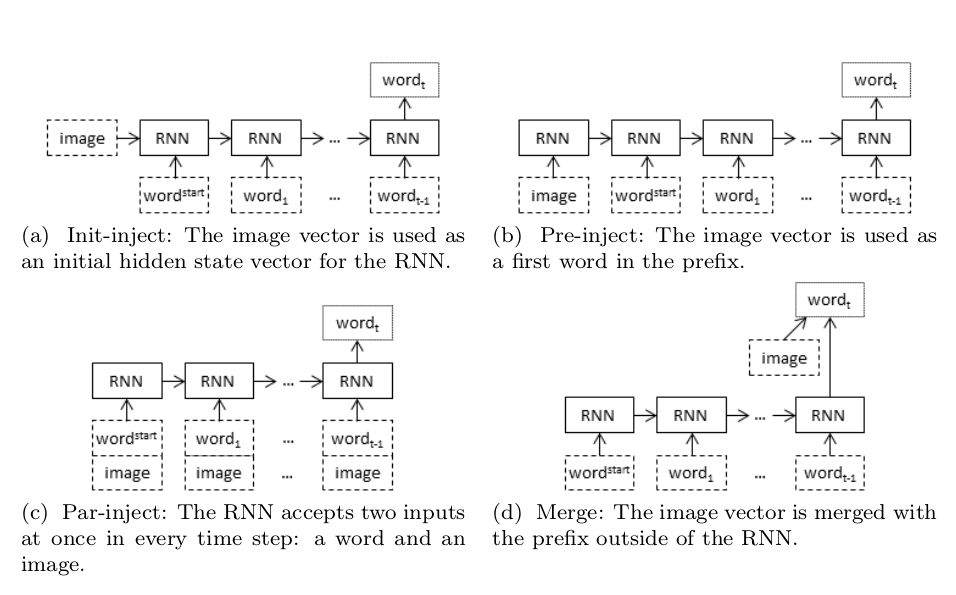

In [359]:
display(Image(filename='Index.png'))

**Reference**: Marc Tanti, Albert Gatt, & Kenneth P. Camilleri (2018) Where to put the Image in an Image Caption Generator (https://arxiv.org/pdf/1703.09137.pdf)

### Architecture: Par-inject CNN - GRU

In [111]:
def create_model_1(seq_input_len, n_input_nodes, n_embedding_nodes, 
                 n_hidden_nodes,output_image_nodes, drop_out, stateful=False, batch_size=None):
    #Input layer
    input_layer_seq = Input(batch_shape=(batch_size,seq_input_len), name='input_layer_seq')
    input_layer_image = Input(shape=(X_train_image.shape[1:]), name = 'input_layer_image')
    
    #Processing sequence input
    embedding_layer_seq = Embedding(input_dim=n_input_nodes, output_dim=n_embedding_nodes, mask_zero=True, name='embedding_layer')(input_layer_seq)
    embedding_layer_seq_1 = Dropout(drop_out)(embedding_layer_seq)
    
    #Processing image input
    output_layer_image = Dropout(drop_out)(input_layer_image)
    output_layer_image_1 = Dense(output_image_nodes, activation="relu", name='output_layer_image')(output_layer_image)
    output_layer_image_2 = RepeatVector(seq_input_len, name ='output_layer_image_1'  )(output_layer_image_1)
    
    #GRU layer
    concat = keras.layers.Concatenate(axis=-1)([embedding_layer_seq_1, output_layer_image_2])
    gru_layer1 = GRU(n_hidden_nodes,return_sequences=True,stateful=stateful, dropout=drop_out, name='hidden_layer1')(concat)
    gru_layer2 = GRU(n_hidden_nodes,return_sequences=True,stateful=stateful, dropout=drop_out, name='hidden_layer2')(gru_layer1)
    
    #output layer
    output = TimeDistributed(Dense(n_input_nodes, activation="softmax"), name='output_layer')(gru_layer2)
    
    
    model = Model(inputs=[input_layer_seq , input_layer_image], outputs=[output])
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy(name = 'sca')])
    return model

In [112]:
model1 = create_model_1(seq_input_len= X_train_language.shape[1],
                     n_input_nodes = len(word_to_int),
                     output_image_nodes = 256,
                     n_embedding_nodes = 256,
                     n_hidden_nodes = 256,
                     drop_out = 0.3)

In [113]:
model1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_image (InputLayer)  [(None, 4096)]      0           []                               
                                                                                                  
 input_layer_seq (InputLayer)   [(None, 50)]         0           []                               
                                                                                                  
 dropout_9 (Dropout)            (None, 4096)         0           ['input_layer_image[0][0]']      
                                                                                                  
 embedding_layer (Embedding)    (None, 50, 256)      1412608     ['input_layer_seq[0][0]']        
                                                                                            

In [115]:
#Dont run it again
start_time = time.time()
history1 = model1.fit(x = [X_train_language, X_train_image], y = Y_train, epochs = 30, batch_size=256,validation_split=0.2,verbose =1,
                     callbacks=[keras.callbacks.EarlyStopping(patience = 5)])
time_model1 = time.time() - start_time
print("--- %s seconds ---" % time_model1)
model1.save_weights('model_weights_ImageCaption1.h5')

Epoch 1/30
40/40 [==============================] - 378s 9s/step - loss: 1.2357 - sca: 0.1850 - val_loss: 1.2279 - val_sca: 0.1941
Epoch 2/30
40/40 [==============================] - 379s 9s/step - loss: 1.2156 - sca: 0.1936 - val_loss: 1.2125 - val_sca: 0.2053
Epoch 3/30
40/40 [==============================] - 393s 10s/step - loss: 1.2018 - sca: 0.1958 - val_loss: 1.2054 - val_sca: 0.2026
Epoch 4/30
40/40 [==============================] - 395s 10s/step - loss: 1.1919 - sca: 0.1994 - val_loss: 1.1948 - val_sca: 0.2037
Epoch 5/30
40/40 [==============================] - 397s 10s/step - loss: 1.1846 - sca: 0.2021 - val_loss: 1.1877 - val_sca: 0.2034
Epoch 6/30
40/40 [==============================] - 390s 10s/step - loss: 1.1782 - sca: 0.2039 - val_loss: 1.1856 - val_sca: 0.1992
Epoch 7/30
40/40 [==============================] - 351s 9s/step - loss: 1.1737 - sca: 0.2043 - val_loss: 1.1808 - val_sca: 0.2009
Epoch 8/30
40/40 [==============================] - 365s 9s/step - loss: 1.1698

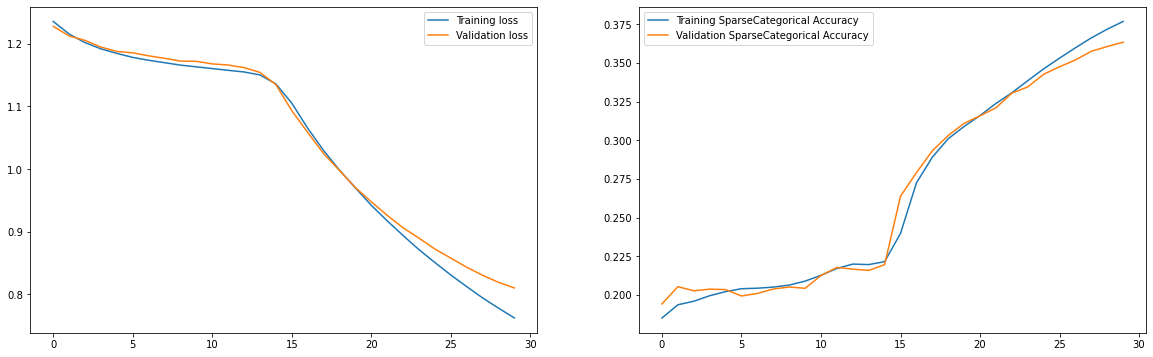

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 6))
ax1.plot(history1.history['loss'], label = 'Training loss')
ax1.plot(history1.history['val_loss'], label = 'Validation loss')
ax1.legend()
ax2.plot(history1.history['sca'], label = 'Training SparseCategorical Accuracy')
ax2.plot(history1.history['val_sca'], label = 'Validation SparseCategorical Accuracy')
ax2.legend()

### Architecture: Merge CNN - GRU

In [119]:
def create_model_2(seq_input_len, n_input_nodes, n_embedding_nodes, 
                 n_hidden_nodes,drop_out,output_image_nodes, stateful=False, batch_size=None):
    #Input layer
    input_layer_seq = Input(batch_shape=(batch_size,seq_input_len), name='input_layer_seq')
    input_layer_image = Input(shape=(X_train_image.shape[1:]), name = 'input_layer_image' )
    
    #Processing sequence input
    embedding_layer_seq = Embedding(input_dim=n_input_nodes, output_dim=n_embedding_nodes, mask_zero=True, name='embedding_layer_seq')(input_layer_seq)
    embedding_layer_seq_1 = Dropout(drop_out)(embedding_layer_seq)
    
    #GRU layer
    gru_layer1 = GRU(n_hidden_nodes,return_sequences=True,stateful=stateful,  name='hidden_layer1')(embedding_layer_seq_1)
    gru_layer2 = GRU(n_hidden_nodes,return_sequences=True,stateful=stateful,  name='hidden_layer2')(gru_layer1)
    
    #Processing image input
    output_layer_image = Dropout(drop_out)(input_layer_image)
    output_layer_image_1 = Dense(output_image_nodes, activation="relu", name='output_layer_image')(output_layer_image)
    output_layer_image_2 = RepeatVector(seq_input_len, name ='output_layer_image_1'  )(output_layer_image_1)
    
    #Output layer
    concat = keras.layers.Concatenate(axis=-1)([gru_layer2, output_layer_image_2])
    output = Dense(256, activation='relu')(concat)
    output_1 = TimeDistributed(Dense(n_input_nodes, activation="softmax"), name='output_layer')(output)
    
    
    model = Model(inputs=[input_layer_seq , input_layer_image], outputs=[output_1])
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy(name = 'sca')])
    return model

In [120]:
model2 = create_model_2(seq_input_len= X_train_language.shape[1],
                     n_input_nodes = len(word_to_int),
                     output_image_nodes = 256,
                     n_embedding_nodes = 256,
                     n_hidden_nodes = 256,
                     drop_out = 0.3)

In [121]:
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_seq (InputLayer)   [(None, 50)]         0           []                               
                                                                                                  
 embedding_layer_seq (Embedding  (None, 50, 256)     1412608     ['input_layer_seq[0][0]']        
 )                                                                                                
                                                                                                  
 input_layer_image (InputLayer)  [(None, 4096)]      0           []                               
                                                                                                  
 dropout_10 (Dropout)           (None, 50, 256)      0           ['embedding_layer_seq[0][0]

In [122]:
#Dont run it again
start_time = time.time()
history2 = model2.fit(x = [X_train_language, X_train_image], y = Y_train, epochs = 30, batch_size=256,validation_split=0.2,verbose =1,
                     callbacks=[keras.callbacks.EarlyStopping(patience = 5)])
time_model2 = time.time() - start_time
print("--- %s seconds ---" % time_model2)
model2.save_weights('model_weights_ImageCaption2.h5')

Epoch 1/30
40/40 [==============================] - 361s 9s/step - loss: 1.3157 - sca: 0.1518 - val_loss: 1.1633 - val_sca: 0.2031
Epoch 2/30
40/40 [==============================] - 353s 9s/step - loss: 1.0460 - sca: 0.2482 - val_loss: 0.9705 - val_sca: 0.2857
Epoch 3/30
40/40 [==============================] - 351s 9s/step - loss: 0.8740 - sca: 0.3143 - val_loss: 0.8699 - val_sca: 0.3298
Epoch 4/30
40/40 [==============================] - 351s 9s/step - loss: 0.7743 - sca: 0.3533 - val_loss: 0.8290 - val_sca: 0.3473
Epoch 5/30
40/40 [==============================] - 351s 9s/step - loss: 0.7128 - sca: 0.3747 - val_loss: 0.8128 - val_sca: 0.3575
Epoch 6/30
40/40 [==============================] - 352s 9s/step - loss: 0.6666 - sca: 0.3934 - val_loss: 0.8038 - val_sca: 0.3648
Epoch 7/30
40/40 [==============================] - 351s 9s/step - loss: 0.6279 - sca: 0.4091 - val_loss: 0.8024 - val_sca: 0.3672
Epoch 8/30
40/40 [==============================] - 352s 9s/step - loss: 0.5960 - s

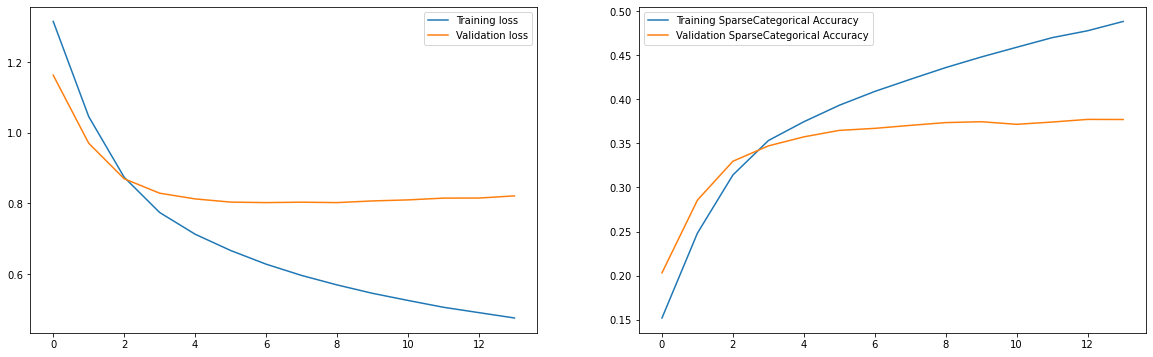

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 6))
ax1.plot(history2.history['loss'], label = 'Training loss')
ax1.plot(history2.history['val_loss'], label = 'Validation loss')
ax1.legend()
ax2.plot(history2.history['sca'], label = 'Training SparseCategorical Accuracy')
ax2.plot(history2.history['val_sca'], label = 'Validation SparseCategorical Accuracy')
ax2.legend()

### Architecture: Par-inject CNN - LSTM

In [126]:
def create_model_3(seq_input_len, n_input_nodes, n_embedding_nodes, 
                 n_hidden_nodes,output_image_nodes, drop_out, stateful=False, batch_size=None):
    #Input layer
    input_layer_seq = Input(batch_shape=(batch_size,seq_input_len), name='input_layer_seq')
    input_layer_image = Input(shape=(X_train_image.shape[1:]), name = 'input_layer_image')
    
    #Processing sequence input
    embedding_layer_seq = Embedding(input_dim=n_input_nodes, output_dim=n_embedding_nodes, mask_zero=True, name='embedding_layer')(input_layer_seq)
    embedding_layer_seq_1 = Dropout(drop_out)(embedding_layer_seq)
    
    #Processing image input
    output_layer_image = Dropout(drop_out)(input_layer_image)
    output_layer_image_1 = Dense(output_image_nodes, activation="relu", name='output_layer_image')(output_layer_image)
    output_layer_image_2 = RepeatVector(seq_input_len, name ='output_layer_image_1'  )(output_layer_image_1)
    
    #LSTM layer
    concat = keras.layers.Concatenate(axis=-1)([embedding_layer_seq_1, output_layer_image_2])
    lstm_layer1 = LSTM(n_hidden_nodes,return_sequences=True,stateful=stateful, dropout=drop_out, name='hidden_layer1')(concat)
    lstm_layer2 = LSTM(n_hidden_nodes,return_sequences=True,stateful=stateful, dropout=drop_out, name='hidden_layer2')(lstm_layer1)
    
    #Output layer
    output = TimeDistributed(Dense(n_input_nodes, activation="softmax"), name='output_layer')(lstm_layer2)
    
    
    model = Model(inputs=[input_layer_seq , input_layer_image], outputs=[output])
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy(name = 'sca')])
    return model

In [127]:
model3 = create_model_3(seq_input_len= X_train_language.shape[1],
                     n_input_nodes = len(word_to_int),
                     output_image_nodes = 256,
                     n_embedding_nodes = 256,
                     n_hidden_nodes = 256,
                     drop_out = 0.3)

In [128]:
model3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_image (InputLayer)  [(None, 4096)]      0           []                               
                                                                                                  
 input_layer_seq (InputLayer)   [(None, 50)]         0           []                               
                                                                                                  
 dropout_13 (Dropout)           (None, 4096)         0           ['input_layer_image[0][0]']      
                                                                                                  
 embedding_layer (Embedding)    (None, 50, 256)      1412608     ['input_layer_seq[0][0]']        
                                                                                            

In [129]:
#Dont run it again
start_time = time.time()
history3 = model3.fit(x = [X_train_language, X_train_image], y = Y_train, epochs = 30, batch_size=256,validation_split=0.2,verbose =1,
                     callbacks=[keras.callbacks.EarlyStopping(patience = 5)])
time_model3 = time.time() - start_time
print("--- %s seconds ---" % time_model3)
model3.save_weights('model_weights_ImageCaption3.h5')

Epoch 1/30
40/40 [==============================] - 455s 11s/step - loss: 1.4340 - sca: 0.1196 - val_loss: 1.2745 - val_sca: 0.1943
Epoch 2/30
40/40 [==============================] - 462s 12s/step - loss: 1.2564 - sca: 0.1860 - val_loss: 1.2459 - val_sca: 0.1830
Epoch 3/30
40/40 [==============================] - 466s 12s/step - loss: 1.2294 - sca: 0.1965 - val_loss: 1.2219 - val_sca: 0.1943
Epoch 4/30
40/40 [==============================] - 469s 12s/step - loss: 1.2100 - sca: 0.1981 - val_loss: 1.2070 - val_sca: 0.1943
Epoch 5/30
40/40 [==============================] - 471s 12s/step - loss: 1.1968 - sca: 0.2007 - val_loss: 1.1966 - val_sca: 0.2023
Epoch 6/30
40/40 [==============================] - 475s 12s/step - loss: 1.1883 - sca: 0.2028 - val_loss: 1.1904 - val_sca: 0.1974
Epoch 7/30
40/40 [==============================] - 487s 12s/step - loss: 1.1819 - sca: 0.2038 - val_loss: 1.1856 - val_sca: 0.2052
Epoch 8/30
40/40 [==============================] - 502s 13s/step - loss: 1.

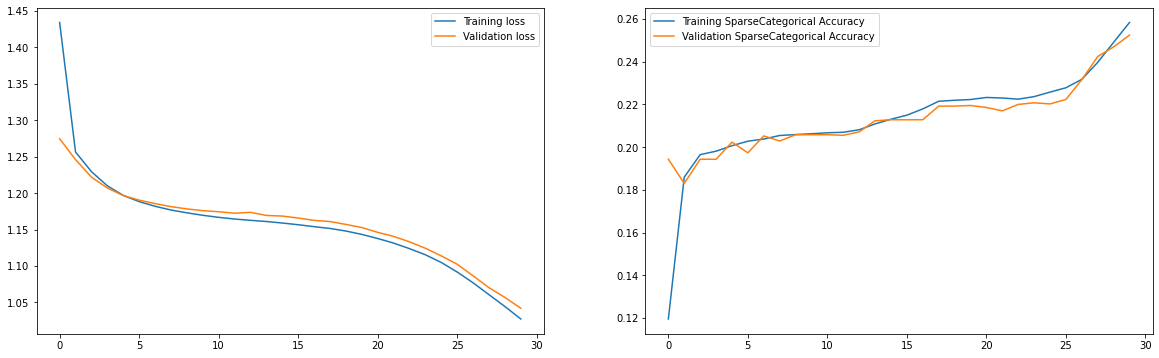

In [168]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 6))
ax1.plot(history3.history['loss'], label = 'Training loss')
ax1.plot(history3.history['val_loss'], label = 'Validation loss')
ax1.legend()
ax2.plot(history3.history['sca'], label = 'Training SparseCategorical Accuracy')
ax2.plot(history3.history['val_sca'], label = 'Validation SparseCategorical Accuracy')
ax2.legend()

### Architecture: Merge CNN - LSTM

In [134]:
def create_model_4(seq_input_len, n_input_nodes, n_embedding_nodes, 
                 n_hidden_nodes,drop_out,output_image_nodes, stateful=False, batch_size=None):
    #Input layer
    input_layer_seq = Input(batch_shape=(batch_size,seq_input_len), name='input_layer_seq')
    input_layer_image = Input(shape=(X_train_image.shape[1:]), name = 'input_layer_image' )
    
    #Processing sequence input
    embedding_layer_seq = Embedding(input_dim=n_input_nodes, output_dim=n_embedding_nodes, mask_zero=True, name='embedding_layer_seq')(input_layer_seq)
    embedding_layer_seq_1 = Dropout(drop_out)(embedding_layer_seq)
    
    #LSTM layer
    lstm_layer1 = GRU(n_hidden_nodes,return_sequences=True,stateful=stateful,  name='hidden_layer1')(embedding_layer_seq_1)
    lstm_layer2 = GRU(n_hidden_nodes,return_sequences=True,stateful=stateful,  name='hidden_layer2')(lstm_layer1)
    
    #Processing image input
    output_layer_image = Dropout(drop_out)(input_layer_image)
    output_layer_image_1 = Dense(output_image_nodes, activation="relu", name='output_layer_image')(output_layer_image)
    output_layer_image_2 = RepeatVector(seq_input_len, name ='output_layer_image_1')(output_layer_image_1)
    
    #Output layer
    concat = keras.layers.Concatenate(axis=-1)([lstm_layer2, output_layer_image_2])
    output = Dense(256, activation='relu')(concat)
    output_1 = TimeDistributed(Dense(n_input_nodes, activation="softmax"),name='output_layer')(output)
    
    
    model = Model(inputs=[input_layer_seq , input_layer_image], outputs=[output_1])
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy(name = 'sca')])
    return model

In [135]:
model4 = create_model_4(seq_input_len= X_train_language.shape[1],
                     n_input_nodes = len(word_to_int),
                     output_image_nodes = 256,
                     n_embedding_nodes = 256,
                     n_hidden_nodes = 256,
                     drop_out = 0.3)

In [136]:
model4.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_seq (InputLayer)   [(None, 50)]         0           []                               
                                                                                                  
 embedding_layer_seq (Embedding  (None, 50, 256)     1412608     ['input_layer_seq[0][0]']        
 )                                                                                                
                                                                                                  
 input_layer_image (InputLayer)  [(None, 4096)]      0           []                               
                                                                                                  
 dropout_14 (Dropout)           (None, 50, 256)      0           ['embedding_layer_seq[0][0]

In [146]:
#Dont run it again
start_time = time.time()
history4 = model4.fit(x = [X_train_language, X_train_image], y = Y_train, epochs = 30, batch_size=256,validation_split=0.2,verbose =1,
                     callbacks=[keras.callbacks.EarlyStopping(patience = 5)])
time_model4 = time.time() - start_time
print("--- %s seconds ---" % time_model4)
model4.save_weights('model_weights_ImageCaption4.h5')

Epoch 1/30
40/40 [==============================] - 645s 16s/step - loss: 1.3078 - sca: 0.1605 - val_loss: 1.1586 - val_sca: 0.2031
Epoch 2/30
40/40 [==============================] - 659s 16s/step - loss: 1.0451 - sca: 0.2489 - val_loss: 0.9904 - val_sca: 0.2750
Epoch 3/30
40/40 [==============================] - 658s 16s/step - loss: 0.8840 - sca: 0.3105 - val_loss: 0.8803 - val_sca: 0.3216
Epoch 4/30
40/40 [==============================] - 645s 16s/step - loss: 0.7815 - sca: 0.3480 - val_loss: 0.8378 - val_sca: 0.3451
Epoch 5/30
40/40 [==============================] - 682s 17s/step - loss: 0.7197 - sca: 0.3710 - val_loss: 0.8214 - val_sca: 0.3531
Epoch 6/30
40/40 [==============================] - 661s 17s/step - loss: 0.6725 - sca: 0.3895 - val_loss: 0.8110 - val_sca: 0.3626
Epoch 7/30
40/40 [==============================] - 655s 16s/step - loss: 0.6343 - sca: 0.4054 - val_loss: 0.8085 - val_sca: 0.3668
Epoch 8/30
40/40 [==============================] - 675s 17s/step - loss: 0.

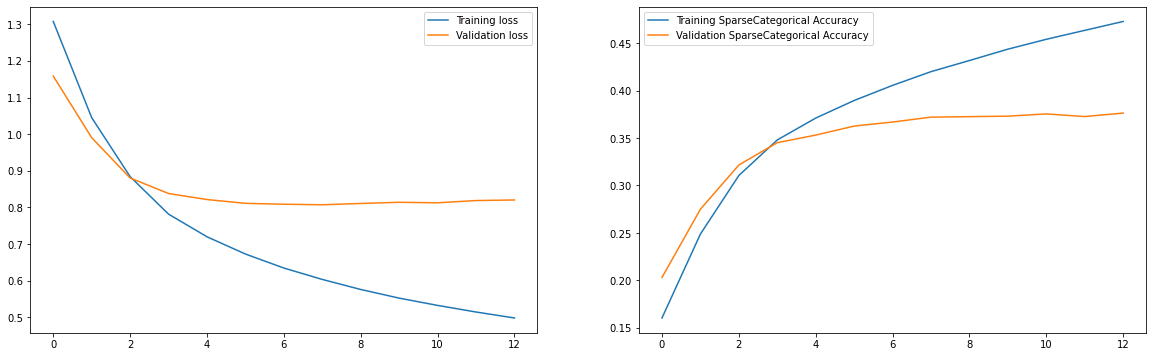

In [169]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 6))
ax1.plot(history4.history['loss'], label = 'Training loss')
ax1.plot(history4.history['val_loss'], label = 'Validation loss')
ax1.legend()
ax2.plot(history4.history['sca'], label = 'Training SparseCategorical Accuracy')
ax2.plot(history4.history['val_sca'], label = 'Validation SparseCategorical Accuracy')
ax2.legend()

## VII. Comparing 2 models: Merge CNN-GRU and Merge CNN-LSTM 

#### Additional train model 2: Merge CNN-GRU

In [153]:
start_time = time.time()
history2plus = model2.fit(x = [X_train_language, X_train_image], y = Y_train, epochs = 16, batch_size=256,validation_split=0.2,verbose =1)
time_model2plus = time.time() - start_time
print("--- %s seconds ---" % time_model2plus)
model2.save_weights('model_weights_ImageCaption2plus.h5')

Epoch 1/16
40/40 [==============================] - 349s 9s/step - loss: 0.4610 - sca: 0.4966 - val_loss: 0.8282 - val_sca: 0.3760
Epoch 2/16
40/40 [==============================] - 359s 9s/step - loss: 0.4496 - sca: 0.5047 - val_loss: 0.8292 - val_sca: 0.3755
Epoch 3/16
40/40 [==============================] - 367s 9s/step - loss: 0.4381 - sca: 0.5140 - val_loss: 0.8351 - val_sca: 0.3772
Epoch 4/16
40/40 [==============================] - 371s 9s/step - loss: 0.4288 - sca: 0.5182 - val_loss: 0.8418 - val_sca: 0.3742
Epoch 5/16
40/40 [==============================] - 456s 11s/step - loss: 0.4185 - sca: 0.5266 - val_loss: 0.8443 - val_sca: 0.3774
Epoch 6/16
40/40 [==============================] - 506s 13s/step - loss: 0.4096 - sca: 0.5335 - val_loss: 0.8491 - val_sca: 0.3778
Epoch 7/16
40/40 [==============================] - 504s 13s/step - loss: 0.4000 - sca: 0.5406 - val_loss: 0.8543 - val_sca: 0.3760
Epoch 8/16
40/40 [==============================] - 503s 13s/step - loss: 0.3927

In [188]:
history2.history['loss'].extend(history2plus.history['loss'])
history2.history['sca'].extend(history2plus.history['sca'])
history2.history['val_loss'].extend(history2plus.history['val_loss'])
history2.history['val_sca'].extend(history2plus.history['val_sca'])
history2.history.update({'time_model': history2.history['time_model']+history2plus.history['time_model']})

#### Additional train model 4: Merge CNN-LSTM

In [154]:
start_time = time.time()
history4plus = model4.fit(x = [X_train_language, X_train_image], y = Y_train, epochs = 17, batch_size=256,validation_split=0.2,verbose =1)
time_model4plus = time.time() - start_time
print("--- %s seconds ---" % time_model4plus)
model4.save_weights('model_weights_ImageCaption4plus.h5')

Epoch 1/17
40/40 [==============================] - 509s 13s/step - loss: 0.4833 - sca: 0.4828 - val_loss: 0.8282 - val_sca: 0.3747
Epoch 2/17
40/40 [==============================] - 525s 13s/step - loss: 0.4706 - sca: 0.4895 - val_loss: 0.8273 - val_sca: 0.3770
Epoch 3/17
40/40 [==============================] - 510s 13s/step - loss: 0.4567 - sca: 0.4997 - val_loss: 0.8305 - val_sca: 0.3759
Epoch 4/17
40/40 [==============================] - 511s 13s/step - loss: 0.4470 - sca: 0.5062 - val_loss: 0.8384 - val_sca: 0.3745
Epoch 5/17
40/40 [==============================] - 517s 13s/step - loss: 0.4362 - sca: 0.5138 - val_loss: 0.8418 - val_sca: 0.3740
Epoch 6/17
40/40 [==============================] - 493s 12s/step - loss: 0.4264 - sca: 0.5211 - val_loss: 0.8460 - val_sca: 0.3741
Epoch 7/17
40/40 [==============================] - 387s 10s/step - loss: 0.4174 - sca: 0.5278 - val_loss: 0.8515 - val_sca: 0.3726
Epoch 8/17
40/40 [==============================] - 393s 10s/step - loss: 0.

In [192]:
history4.history['loss'].extend(history4plus.history['loss'])
history4.history['sca'].extend(history4plus.history['sca'])
history4.history['val_loss'].extend(history4plus.history['val_loss'])
history4.history['val_sca'].extend(history4plus.history['val_sca'])
history4.history.update({'time_model': history4.history['time_model']+history4plus.history['time_model']})

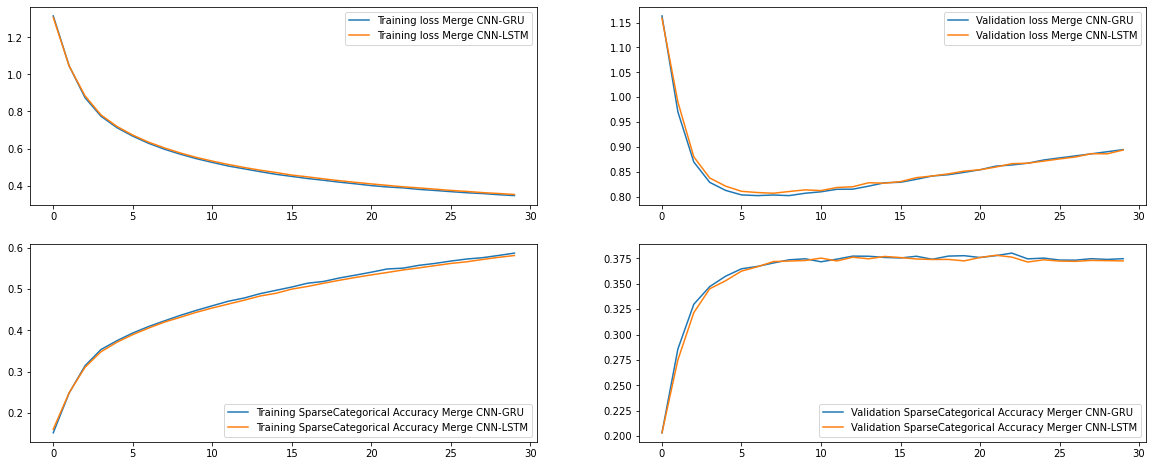

In [366]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20, 8))
ax1.plot(history2.history['loss'], label = 'Training loss Merge CNN-GRU')
ax1.plot(history4.history['loss'], label = 'Training loss Merge CNN-LSTM')
ax1.legend()
ax2.plot(history2.history['val_loss'], label = 'Validation loss Merge CNN-GRU')
ax2.plot(history4.history['val_loss'], label = 'Validation loss Merge CNN-LSTM')
ax2.legend()
ax3.plot(history2.history['sca'], label = 'Training SparseCategorical Accuracy Merge CNN-GRU')
ax3.plot(history4.history['sca'], label = 'Training SparseCategorical Accuracy Merge CNN-LSTM')
ax3.legend()
ax4.plot(history2.history['val_sca'], label = 'Validation SparseCategorical Accuracy Merger CNN-GRU')
ax4.plot(history4.history['val_sca'], label = 'Validation SparseCategorical Accuracy Merger CNN-LSTM')
ax4.legend()

In [377]:
Comparision = dict()
Comparision['Par_int CNN-GRU'] = {}
Comparision['Par_int CNN-GRU']['TrainingTime'] = history1.history['time_model']
Comparision['Par_int CNN-GRU']['Sparse Categorical Accuracy'] = history1.history['val_sca'][-1]
Comparision['Merge CNN-GRU'] = {}
Comparision['Merge CNN-GRU']['TrainingTime'] = history2.history['time_model']
Comparision['Merge CNN-GRU']['Sparse Categorical Accuracy'] = history2.history['val_sca'][-1]
Comparision['Par_int CNN-LSTM'] = {}
Comparision['Par_int CNN-LSTM']['TrainingTime'] = history3.history['time_model']
Comparision['Par_int CNN-LSTM']['Sparse Categorical Accuracy'] = history3.history['val_sca'][-1]
Comparision['Merge CNN-LSTM'] = {}
Comparision['Merge CNN-LSTM']['TrainingTime'] = history4.history['time_model']
Comparision['Merge CNN-LSTM']['Sparse Categorical Accuracy'] = history4.history['val_sca'][-1]

In [378]:
pd.DataFrame.from_dict(Comparision, orient = 'index')

,TrainingTime,Sparse Categorical Accuracy
Par_int CNN-GRU,10803.376716,0.363363
Merge CNN-GRU,12416.087587,0.374812
Par_int CNN-LSTM,17099.960533,0.252417
Merge CNN-LSTM,15552.162855,0.372631


## VIII. Prediction & Evaluation

#### 1. Pediction

In [401]:
model_final = create_model_2(seq_input_len= X_train_language.shape[1],
                     n_input_nodes = len(word_to_int),
                     output_image_nodes = 256,
                     n_embedding_nodes = 256,
                     n_hidden_nodes = 256,
                     drop_out = 0.3)

In [402]:
model_final.load_weights('model_weights_ImageCaption2.h5')

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    max_caption_len = 51
    start = [word_to_int["<start>"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_caption_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_caption_len-1)
            preds = model_final.predict([par_caps,image], verbose=0)
            word_preds = np.argsort(preds[0][-1])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][-1][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [int_to_word[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != "<end>":
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

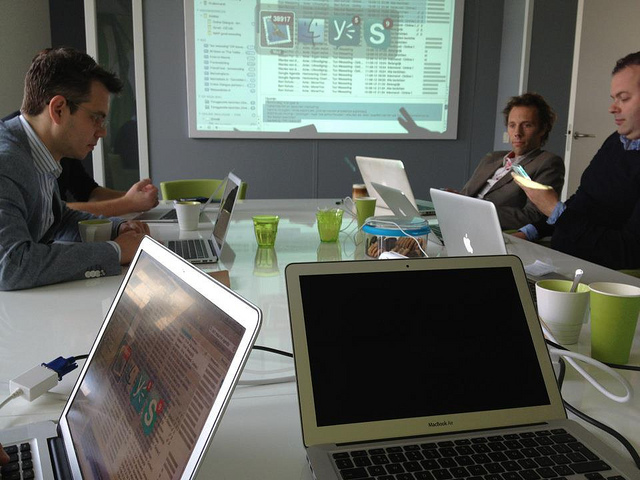

['<start> We are looking over two laptops at men having a meeting. <end>',
 '<start> A group of people sitting at a table with laptop computers. <end>',
 '<start> a couple of laptops sitting on a table <end>',
 '<start> A group of people sit around a table using notebook computers. <end>',
 '<start> A group of people sitting at a conference table with laptop '
 'computers. <end>']


In [403]:
#urllib.request.urlretrieve(test_image_paths[420], test_image_paths[3][-16:])
display(Image(filename=test_image_paths[3][-16:]))
pprint.pprint(image_path_to_caption[test_image_paths[3]])

In [404]:
image_test = load_image(test_image_paths[3])
image_test.shape

(1, 4096)

In [405]:
Caption_beam_index_3 = beam_search_predictions(image = image_test,beam_index = 3 )
Caption_beam_index_5 = beam_search_predictions(image = image_test,beam_index = 5 )
Caption_beam_index_7 = beam_search_predictions(image = image_test,beam_index = 7 )

In [406]:
print("Beam Search, K = 3:",Caption_beam_index_3)
print("Beam Search, K = 5:",Caption_beam_index_5)
print("Beam Search, K = 7:",Caption_beam_index_7)

Beam Search, K = 3: a couple of people sitting next to a laptop computer.
Beam Search, K = 5: a couple of people sitting next to a laptop computer.
Beam Search, K = 7: a couple of people sitting next to a laptop computer.


#### 2. Evaluation by BLEU Score

In [258]:
test_image_extract_feature_arrays = []
for image_path in test_image_paths:
    test_image_extract_feature = load_image(image_path)
    test_image_extract_feature_arrays.extend([test_image_extract_feature])

In [ ]:
refs = list() 
predicts = list()
corpus_bleu = dict()

In [ ]:
for i in range(len(test_image_paths)):
    refs.append([ref.split() for ref in image_path_to_caption[test_image_paths[i]]])
    Caption_beam_index_3 = beam_search_predictions(image = test_image_extract_feature_arrays[i],beam_index = 3 )
    predicts.append([Caption_beam_index_3]*len(refs[i]))
    corpus_bleu[test_image_paths[i][-16:]] = {}
    corpus_bleu[test_image_paths[i][-16:]]['BLEU-1'] = nltk.translate.bleu_score.corpus_bleu(refs[i], predicts[i], weights = (1.0,0.0,0.0,0.0))
    corpus_bleu[test_image_paths[i][-16:]]['BLEU-2'] = nltk.translate.bleu_score.corpus_bleu(refs[i], predicts[i], weights = (0.5,0.5,0.0,0.0))

In [407]:
corpus_bleu_df = pd.DataFrame.from_dict(corpus_bleu, orient = 'index')

In [408]:
corpus_bleu_df.head(10)

,BLEU-1,BLEU-2
000000274697.jpg,0.319231,0.289614
000000087320.jpg,0.275000,0.112660
000000460862.jpg,0.369811,0.367591
000000371239.jpg,0.346939,0.243452
000000212635.jpg,0.334483,0.265363
000000239559.jpg,0.390244,0.333496
000000530650.jpg,0.280000,0.216465
000000461819.jpg,0.372727,0.390587
000000454258.jpg,0.395122,0.338505
000000492040.jpg,0.263333,0.231429


In [417]:
print("Bleu-1 score is")
corpus_bleu_df[['BLEU-1']].mean()

Bleu-1 score is


BLEU-1    0.350931
dtype: float64

In [418]:
print("Bleu-2 score is")
corpus_bleu_df[['BLEU-2']].mean()

Bleu-2 score is


BLEU-2    0.275741
dtype: float64

## IX. Tuning hyper-parameters

#### We experimented different values of hyper-parameters 
- Number of epochs
- Number of embedding nodes
- Number of output_image_nodes
- Number of units in each GRU layer (Architecture Merge CNN - GRU)
- Batch size
- Drop_out


#### 1. Number of epochs, batch size, drop-out

In [150]:
tuning_df = pd.DataFrame()

In [151]:
output_image_nodes = 256
n_embedding_nodes = 256
gru_nodes = 256

for epochs in [5, 15]:
    for batch_size in [128, 256]:
        for drop_out in [0.1, 0.2, 0.3]:
            exp_model = create_model_2(seq_input_len= X_train_language.shape[1],
                                       n_input_nodes = len(word_to_int),
                                       output_image_nodes = output_image_nodes,
                                       n_embedding_nodes = n_embedding_nodes,
                                       n_hidden_nodes = gru_nodes,
                                       drop_out = drop_out)
            exp_history = exp_model.fit(x = [X_train_language, X_train_image], y = Y_train, epochs = epochs, batch_size=batch_size,validation_split=0.2,verbose =1,
                                        callbacks=[keras.callbacks.EarlyStopping(patience = 5)])
            tuning_df = tuning_df.append(pd.Series([epochs,batch_size,output_image_nodes,n_embedding_nodes, gru_nodes,drop_out, 
                               exp_history.history['loss'][-1], exp_history.history['val_loss'][-1],
                               exp_history.history['sca'][-1], exp_history.history['val_sca'][-1]]),ignore_index=True)

Epoch 1/5
157/157 [==============================] - 615s 4s/step - loss: 1.0757 - sca: 0.2485 - val_loss: 0.8800 - val_sca: 0.3293
Epoch 2/5
157/157 [==============================] - 617s 4s/step - loss: 0.7782 - sca: 0.3604 - val_loss: 0.8105 - val_sca: 0.3587
Epoch 3/5
157/157 [==============================] - 631s 4s/step - loss: 0.6745 - sca: 0.3956 - val_loss: 0.7960 - val_sca: 0.3676
Epoch 4/5
157/157 [==============================] - 597s 4s/step - loss: 0.6071 - sca: 0.4229 - val_loss: 0.7968 - val_sca: 0.3755
Epoch 5/5
157/157 [==============================] - 593s 4s/step - loss: 0.5563 - sca: 0.4447 - val_loss: 0.8003 - val_sca: 0.3755
Epoch 1/5
157/157 [==============================] - 573s 4s/step - loss: 1.1011 - sca: 0.2385 - val_loss: 0.8915 - val_sca: 0.3245
Epoch 2/5
157/157 [==============================] - 567s 4s/step - loss: 0.7878 - sca: 0.3564 - val_loss: 0.8084 - val_sca: 0.3597
Epoch 3/5
157/157 [==============================] - 570s 4s/step - loss: 0.

#### 2. Number of output_image_nodes, embedding nodes, gru nodes

In [155]:
epochs = 5
batch_size = 128
drop_out = 0.3

for output_image_nodes in [128, 256]:
    for n_embedding_nodes in [128, 256]:
        for gru_nodes in [64, 128, 256]:
            exp_model = create_model_2(seq_input_len= X_train_language.shape[1],
                                       n_input_nodes = len(word_to_int),
                                       output_image_nodes = output_image_nodes,
                                       n_embedding_nodes = n_embedding_nodes,
                                       n_hidden_nodes = gru_nodes,
                                       drop_out = drop_out)
            exp_history = exp_model.fit(x = [X_train_language, X_train_image], y = Y_train, epochs = epochs, batch_size=batch_size,validation_split=0.2,verbose =1,
                                        callbacks=[keras.callbacks.EarlyStopping(patience = 5)])
            tuning_df = tuning_df.append(pd.Series([epochs,batch_size,output_image_nodes,n_embedding_nodes, gru_nodes,drop_out, 
                               exp_history.history['loss'][-1], exp_history.history['val_loss'][-1],
                               exp_history.history['sca'][-1], exp_history.history['val_sca'][-1]]),ignore_index=True)

Epoch 1/5
157/157 [==============================] - 320s 2s/step - loss: 1.1526 - sca: 0.2072 - val_loss: 0.9701 - val_sca: 0.2845
Epoch 2/5
157/157 [==============================] - 310s 2s/step - loss: 0.8516 - sca: 0.3177 - val_loss: 0.8545 - val_sca: 0.3307
Epoch 3/5
157/157 [==============================] - 309s 2s/step - loss: 0.7393 - sca: 0.3609 - val_loss: 0.8279 - val_sca: 0.3516
Epoch 4/5
157/157 [==============================] - 311s 2s/step - loss: 0.6756 - sca: 0.3852 - val_loss: 0.8215 - val_sca: 0.3601
Epoch 5/5
157/157 [==============================] - 310s 2s/step - loss: 0.6318 - sca: 0.4032 - val_loss: 0.8247 - val_sca: 0.3644
Epoch 1/5
157/157 [==============================] - 384s 2s/step - loss: 1.1349 - sca: 0.2190 - val_loss: 0.9368 - val_sca: 0.2920
Epoch 2/5
157/157 [==============================] - 380s 2s/step - loss: 0.8303 - sca: 0.3300 - val_loss: 0.8384 - val_sca: 0.3441
Epoch 3/5
157/157 [==============================] - 379s 2s/step - loss: 0.

In [161]:
tuning_df.columns = ['epochs','batch_size','output_image_nodes','n_embedding_nodes', 'gru_nodes','drop_out',
                    'train_loss','val_loss', 'train_sca','val_sca']

In [162]:
tuning_df

,epochs,batch_size,output_image_nodes,n_embedding_nodes,gru_nodes,drop_out,train_loss,val_loss,train_sca,val_sca
0,5.0,128.0,256.0,256.0,256.0,0.1,0.556277,0.800320,0.444678,0.375510
1,5.0,128.0,256.0,256.0,256.0,0.2,0.562295,0.793439,0.441654,0.379350
2,5.0,128.0,256.0,256.0,256.0,0.3,0.572100,0.790486,0.436086,0.378896
3,5.0,256.0,256.0,256.0,256.0,0.1,0.611740,0.802414,0.420167,0.369978
4,5.0,256.0,256.0,256.0,256.0,0.2,0.622088,0.798868,0.413030,0.371287
5,5.0,256.0,256.0,256.0,256.0,0.3,0.630141,0.796209,0.409584,0.371549
6,15.0,128.0,256.0,256.0,256.0,0.1,0.434307,0.834738,0.514939,0.378251
7,15.0,128.0,256.0,256.0,256.0,0.2,0.442070,0.827215,0.509868,0.378652
8,15.0,128.0,256.0,256.0,256.0,0.3,0.458718,0.820327,0.498453,0.380781
9,15.0,256.0,256.0,256.0,256.0,0.1,0.455995,0.837374,0.500065,0.375284


**Discussion**
- 15 epochs performed better than 5 epochs. We might increase number of epochs to improve the model.
- Batch size of 128 better than 256.
- 256 unit in each GRU layer, output image and embedding performed the best, we can increase number of units to improve the model.
- Drop-out of 30% has higher accuracy than 10% and 20%. We might increase drop-out rate to avoid overfitting in the model.

## X.Conclusion

- Architecture Merge (CNN and RNN) gives us better result than Par-injection architecture.
- Model which combining Merge CNN-GRU is slightly better than Merge CNN-LSTM model and training-time is faster as well.
- Beam search algorithm can increase accuracy of predicted caption.
- We can avoid overfitting problem by decrease number of batch size and increase drop_out rate.
- The more units in RNN layer, the better the results

## References

Marc Tanti, Albert Gatt, & Kenneth P. Camilleri (2018) Where to put the Image in an Image Caption Generator (https://arxiv.org/pdf/1703.09137.pdf) <br>
Attention implementation in captioning: https://arxiv.org/pdf/1502.03044.pdf <br>
RNN’s Applications:https://arxiv.org/pdf/1708.02043.pdf